# Image classification

In [1]:
import time
from collections import OrderedDict

import numpy as np
import torch
import torchvision
from IPython.display import display
from matplotlib import pyplot as plt
from pandas import DataFrame
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestCentroid

In [2]:
labels = [
    'top', 'trousers', 'pullover', 'dress', 'coat',
    'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

In [3]:
data = torchvision.datasets.FashionMNIST(
    root='../data/fashion-mnist', train=True, download=True)
train_x, val_x, train_y, val_y = train_test_split(
    np.array(data.data), np.array(data.targets), test_size=5000, random_state=1234)

data = torchvision.datasets.FashionMNIST(
    root='../data/fashion-mnist', train=False, download=True)
test_x = np.array(data.data)
test_y = np.array(data.targets)

In [4]:
data = OrderedDict()
for name, y in (('training', train_y), ('validation', val_y), ('test', test_y)):
    _, counts = np.unique(y, return_counts=True)
    data[f'{name} set'] = OrderedDict([(labels[i], c) for i, c in enumerate(counts)])
    data[f'{name} set']['total'] = y.shape[0]
display(DataFrame(data).T)

,top,trousers,pullover,dress,coat,sandal,shirt,sneaker,bag,ankle boot,total
training set,5513,5500,5502,5518,5463,5486,5470,5484,5547,5517,55000
validation set,487,500,498,482,537,514,530,516,453,483,5000
test set,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,10000


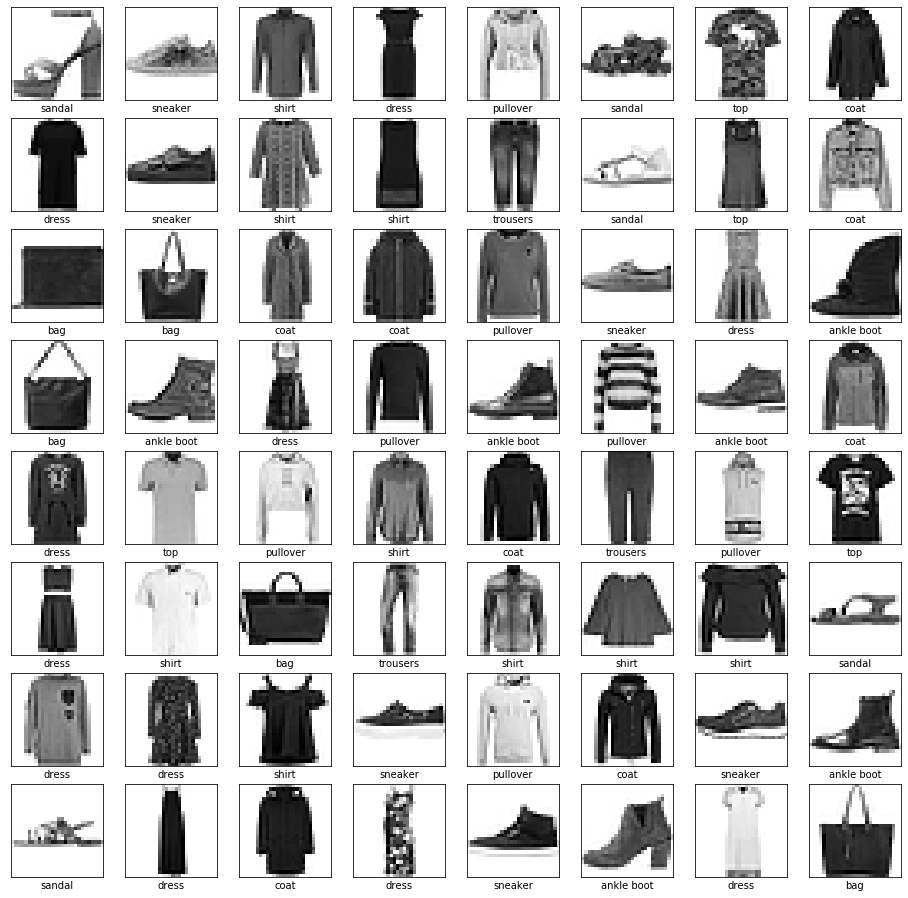

In [5]:
plt.figure(figsize=(16, 16))
for i in range(64):
    plt.subplot(8, 8, i + 1)
    plt.imshow(val_x[i], cmap=plt.cm.binary)
    plt.xlabel(labels[val_y[i]])
    plt.xticks([])
    plt.yticks([])
plt.show()

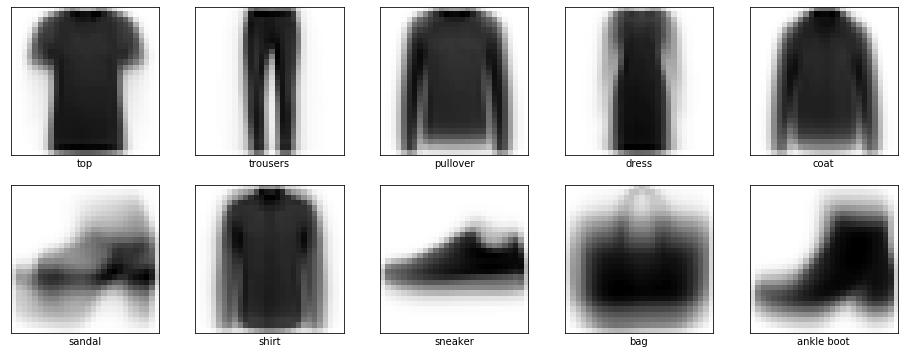

In [6]:
centroids = [(l, train_x[train_y == i].mean(axis=0)) for i, l in enumerate(labels)]
plt.figure(figsize=(16, 6))
for i, (label, image) in enumerate(centroids):
    plt.subplot(2, 5, i + 1)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(label)
    plt.xticks([])
    plt.yticks([])
plt.show()

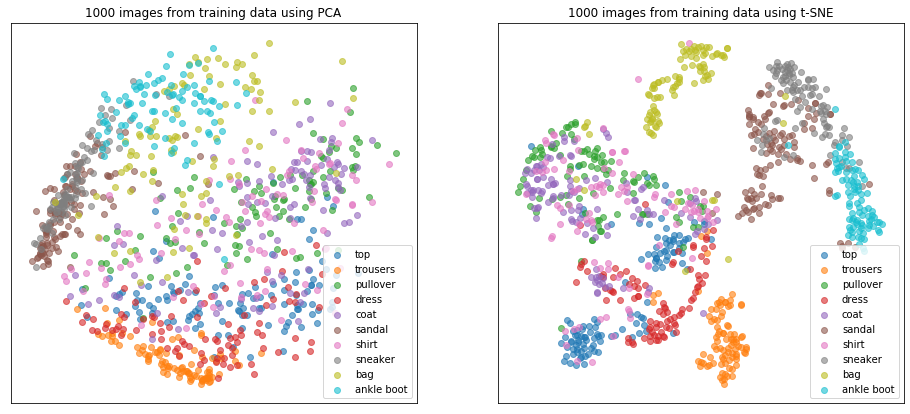

In [7]:
plt.figure(figsize=(16, 7))
for i, (name, alg) in enumerate([
        ('PCA', PCA(n_components=2)), ('t-SNE', TSNE(n_components=2))]):
    x_reduced = alg.fit_transform(train_x[:1000].reshape(-1, 784))
    y_reduced = train_y[:1000]
    data = [(l, x_reduced[y_reduced == i]) for i, l in enumerate(labels)]
    plt.subplot(1, 2, i + 1)
    for label, points in data:
        plt.scatter(points[:, 0], points[:, 1], alpha=0.6, label=label)
    plt.title(f'1000 images from training data using {name}')
    plt.legend()
    plt.xticks([])
    plt.yticks([])
plt.show()

In [8]:
def plot_history(history):
    plt.figure(figsize=(16, 5))
    for i, (name, key) in enumerate([('accuracy', 'acc'), ('loss', 'loss')]):
        plt.subplot(1, 2, i + 1)
        plt.plot(history['epoch'], history[key], label=f'training {name}')
        plt.plot(history['epoch'], history[f'val_{key}'], label=f'validation {name}')
        plt.title(f'{name} during training')
        plt.legend()
        plt.xlabel('epoch')
        plt.ylabel(name)
    plt.show()

def plot_predictions(model, x=val_x[:64], y=val_y[:64], labels=labels):
    y_pred = model.predict(x)
    n = np.ceil(np.sqrt(x.shape[0]))
    plt.figure(figsize=(16, 18))
    for i in range(x.shape[0]):
        plt.subplot(n, n, i + 1)
        plt.imshow(x[i], cmap=plt.cm.binary)
        plt.xlabel(
            f'pred: {labels[y_pred[i]]}\ntrue: {labels[y[i]]}',
            color='green' if y_pred[i] == y[i] else 'red')
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [9]:
models = OrderedDict()

In [10]:
class SKLearnClassifier:

    def __init__(self, model):
        self.model = model

    def fit(self, train_x, train_y):
        start = time.time()
        self.model.fit(train_x.reshape(train_x.shape[0], -1), train_y)
        print(f'Finished training in {time.time() - start:.2f}s')

    def predict(self, x):
        return self.model.predict(x.reshape(x.shape[0], -1))

In [11]:
models['nearest centroid'] = SKLearnClassifier(NearestCentroid(metric='euclidean'))

In [12]:
models['nearest centroid'].fit(train_x, train_y)

Finished training in 0.05s


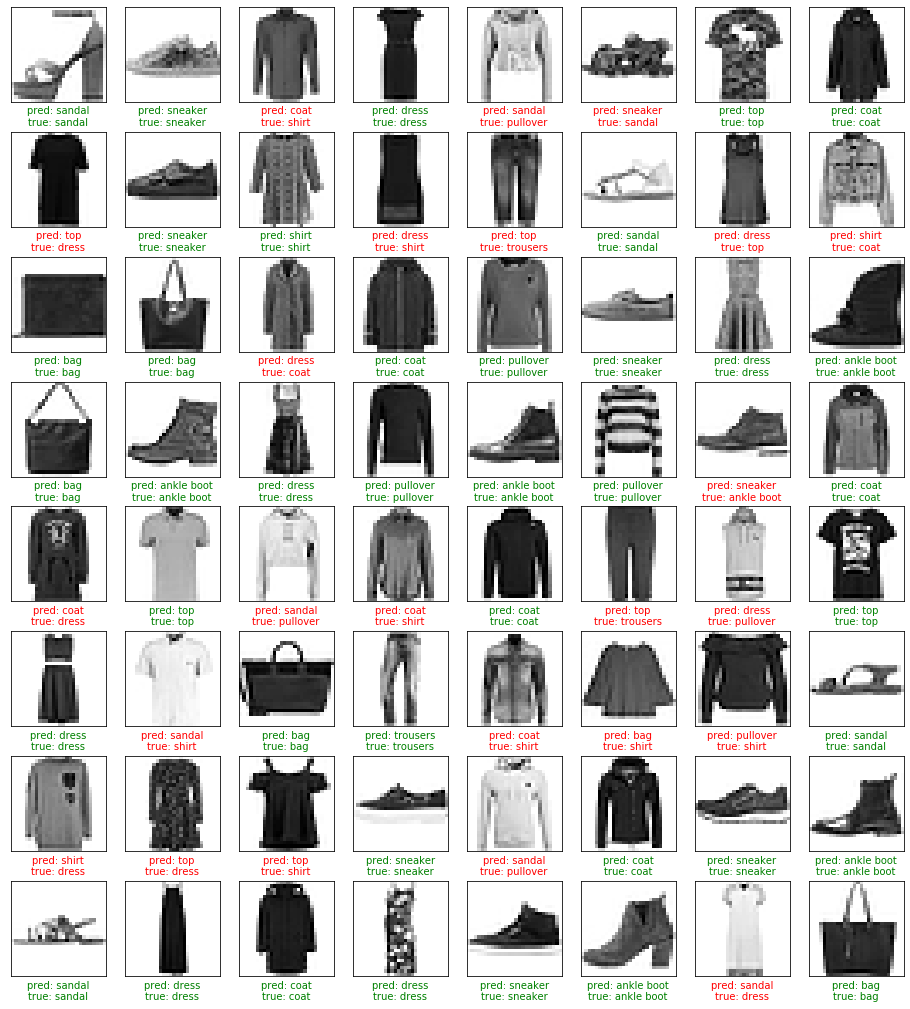

In [13]:
plot_predictions(models['nearest centroid'])

In [14]:
models['random forest'] = SKLearnClassifier(
    RandomForestClassifier(n_estimators=50, max_depth=25, n_jobs=-1))

In [15]:
models['random forest'].fit(train_x, train_y)

Finished training in 6.74s


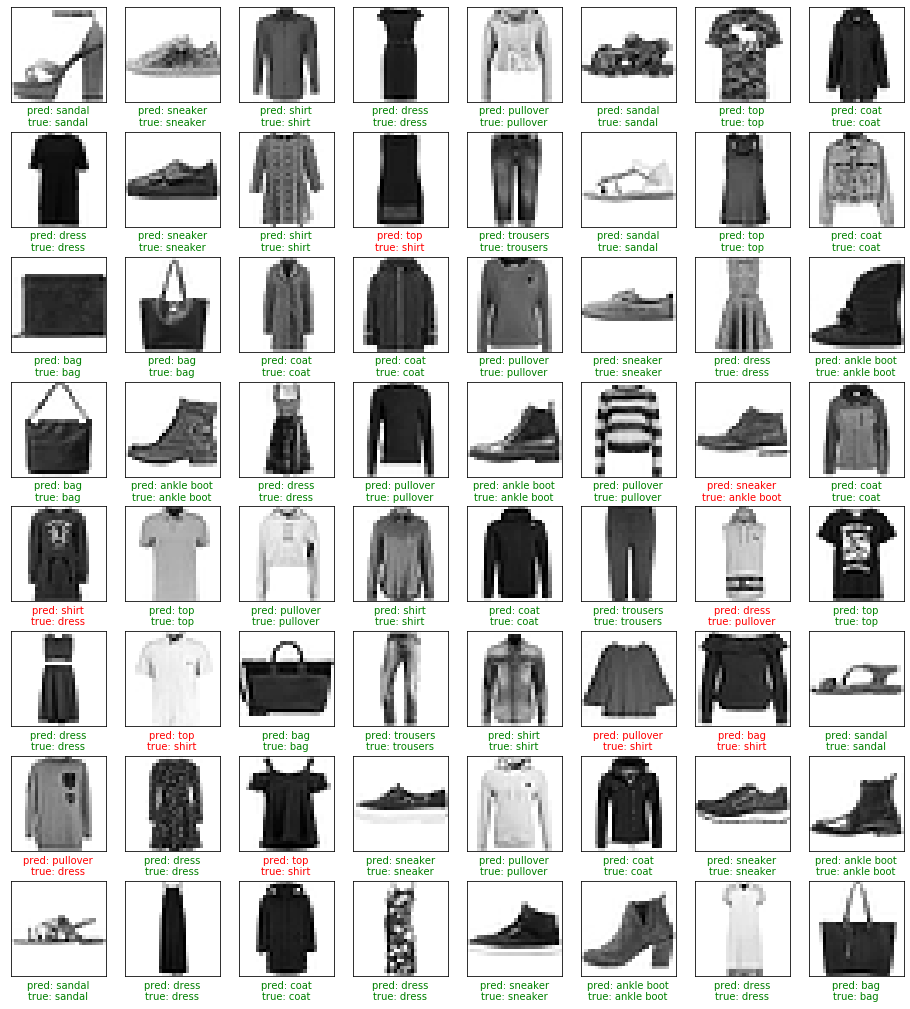

In [16]:
plot_predictions(models['random forest'])

In [17]:
class PyTorchClassifier(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def fit(self, train_x, train_y, val_x, val_y, epochs, batch_size=250, shuffle=True):
        self.to(self.device)
        train_loader = self._build_loader_xy(
            train_x, train_y, batch_size=batch_size, shuffle=shuffle)
        val_loader = self._build_loader_xy(val_x, val_y, batch_size=1000, shuffle=False)
        history = {'epoch': [], 'loss': [], 'acc': [], 'val_loss': [], 'val_acc': []}
        for epoch in range(1, epochs+1):
            self.train()
            start_time = time.time()
            loss, acc = 0, 0
            for x, y in train_loader:
                # Batch training step
                self.optimizer.zero_grad()
                x, y = x.to(self.device), y.to(self.device)
                y_pred = self(x)
                loss_ = self.loss(y_pred, y)
                loss_.backward()
                self.optimizer.step()
                # Calculate metrics for batch
                loss += float(loss_) * len(x)
                acc += int((y_pred.argmax(dim=1) == y).sum())
            # Calculate metrics for epoch
            loss /= len(train_loader.dataset)
            acc /= len(train_loader.dataset)
            val_loss, val_acc = self._evaluate(val_loader)
            duration = time.time() - start_time
            # Save training history
            history['epoch'].append(epoch)
            history['loss'].append(loss)
            history['acc'].append(acc)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            print(
                f'[{epoch:{len(str(epochs))}}/{epochs}] {duration:.1f}s'
                f' - loss: {loss:.4f} - acc: {acc:.4f}'
                f' - val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f}')
        return history

    def predict(self, x, batch_size=1000):
        self.to(self.device)
        data_loader = self._build_loader_x(x, batch_size=batch_size, shuffle=False)
        self.eval()
        preds = []
        with torch.no_grad():
            for x, in data_loader:
                x = x.to(self.device)
                preds.extend(self(x).argmax(dim=1).cpu())
        return np.array(preds)

    def _evaluate(self, data_loader):
        self.to(self.device)
        self.eval()
        loss, acc = 0, 0
        with torch.no_grad():
            for x, y in data_loader:
                x, y = x.to(self.device), y.to(self.device)
                y_pred = self(x)
                loss += float(self.loss(y_pred, y)) * len(x)
                acc += int((y_pred.argmax(dim=1) == y).sum())
        loss /= len(data_loader.dataset)
        acc /= len(data_loader.dataset)
        return loss, acc

    @staticmethod
    def _build_loader_x(x, batch_size, shuffle):
        return torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(torch.FloatTensor(x) / 255),
            batch_size=batch_size, shuffle=shuffle)

    @staticmethod
    def _build_loader_xy(x, y, batch_size, shuffle):
        return torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(torch.FloatTensor(x) / 255, torch.LongTensor(y)),
            batch_size=batch_size, shuffle=shuffle)

In [18]:
class MultilayerPerceptron(PyTorchClassifier):

    def __init__(self):
        super().__init__()
        self.layers = torch.nn.ModuleList([
            torch.nn.Dropout(0.25),
            torch.nn.Linear(784, 150),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.25),
            torch.nn.Linear(150, 10),
        ])
        
        self.loss = torch.nn.functional.cross_entropy
        self.optimizer = torch.optim.Adam(self.parameters())

    def forward(self, x):
        x = x.view(x.size()[0], -1)
        for layer in self.layers:
            x = layer(x)
        return x

In [19]:
models['multilayer perceptron'] = MultilayerPerceptron()

In [20]:
history = models['multilayer perceptron'].fit(train_x, train_y, val_x, val_y, epochs=50)

[ 1/50] 1.0s - loss: 0.7391 - acc: 0.7477 - val_loss: 0.5132 - val_acc: 0.8234
[ 2/50] 0.8s - loss: 0.5107 - acc: 0.8201 - val_loss: 0.4574 - val_acc: 0.8342
[ 3/50] 0.8s - loss: 0.4635 - acc: 0.8354 - val_loss: 0.4134 - val_acc: 0.8526
[ 4/50] 0.8s - loss: 0.4369 - acc: 0.8437 - val_loss: 0.3988 - val_acc: 0.8546
[ 5/50] 0.9s - loss: 0.4181 - acc: 0.8486 - val_loss: 0.3862 - val_acc: 0.8608
[ 6/50] 0.9s - loss: 0.4014 - acc: 0.8547 - val_loss: 0.3710 - val_acc: 0.8650
[ 7/50] 0.9s - loss: 0.3926 - acc: 0.8557 - val_loss: 0.3576 - val_acc: 0.8678
[ 8/50] 0.8s - loss: 0.3835 - acc: 0.8600 - val_loss: 0.3501 - val_acc: 0.8732
[ 9/50] 0.8s - loss: 0.3742 - acc: 0.8642 - val_loss: 0.3431 - val_acc: 0.8748
[10/50] 0.8s - loss: 0.3669 - acc: 0.8673 - val_loss: 0.3440 - val_acc: 0.8744
[11/50] 0.8s - loss: 0.3606 - acc: 0.8665 - val_loss: 0.3393 - val_acc: 0.8738
[12/50] 0.8s - loss: 0.3567 - acc: 0.8695 - val_loss: 0.3331 - val_acc: 0.8824
[13/50] 0.8s - loss: 0.3514 - acc: 0.8705 - val_loss

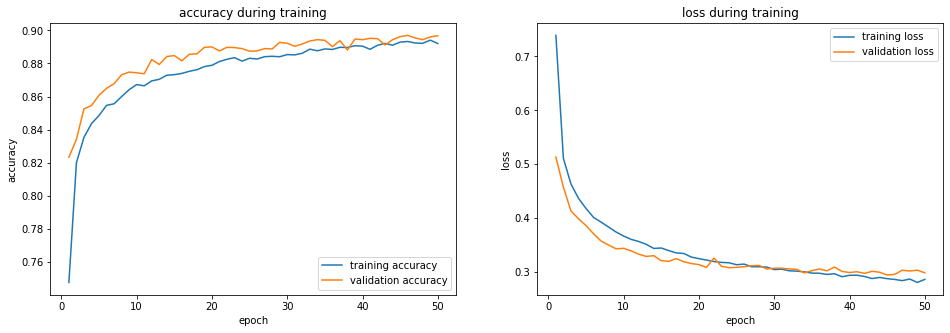

In [21]:
plot_history(history)

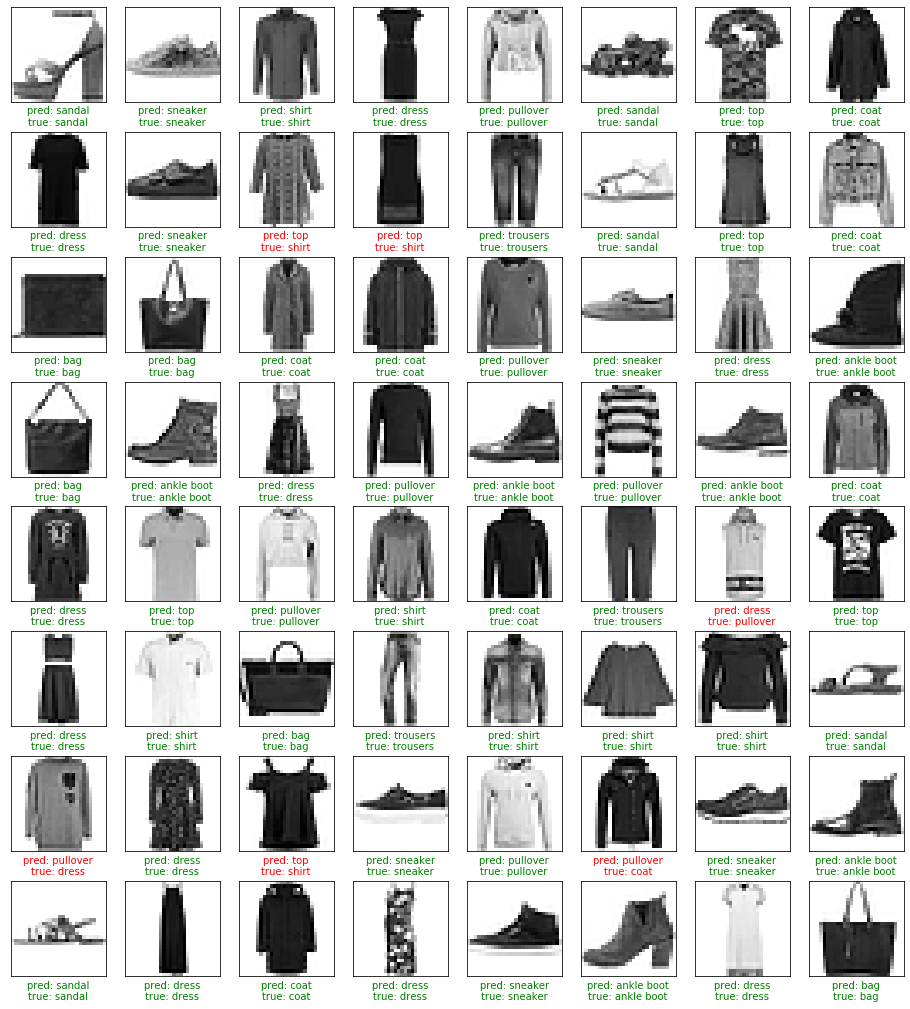

In [22]:
plot_predictions(models['multilayer perceptron'])

In [23]:
class ConvolutionalNet(PyTorchClassifier):

    def __init__(self):
        super().__init__()
        self.layers1 = torch.nn.ModuleList([
            torch.nn.Conv2d(1, 32, 5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Dropout2d(0.25),
            torch.nn.Conv2d(32, 64, 5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Dropout2d(0.25),
            torch.nn.Conv2d(64, 128, 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
        ])
        self.layers2 = torch.nn.ModuleList([
            torch.nn.Dropout(0.25),
            torch.nn.Linear(512, 150),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.25),
            torch.nn.Linear(150, 10),
        ])

        self.loss = torch.nn.functional.cross_entropy
        self.optimizer = torch.optim.Adam(self.parameters())

    def forward(self, x):
        x = x.view(x.size()[0], 1, *x.size()[1:])
        for layer in self.layers1:
            x = layer(x)
        x = x.view(x.size()[0], -1)
        for layer in self.layers2:
            x = layer(x)
        return x

In [24]:
models['convolutional net'] = ConvolutionalNet()

In [25]:
history = models['convolutional net'].fit(train_x, train_y, val_x, val_y, epochs=50)

[ 1/50] 3.5s - loss: 0.9267 - acc: 0.6614 - val_loss: 0.5664 - val_acc: 0.7830
[ 2/50] 3.6s - loss: 0.5805 - acc: 0.7879 - val_loss: 0.4841 - val_acc: 0.8216
[ 3/50] 3.4s - loss: 0.4961 - acc: 0.8213 - val_loss: 0.4107 - val_acc: 0.8514
[ 4/50] 3.3s - loss: 0.4534 - acc: 0.8366 - val_loss: 0.3784 - val_acc: 0.8624
[ 5/50] 3.3s - loss: 0.4154 - acc: 0.8494 - val_loss: 0.3546 - val_acc: 0.8686
[ 6/50] 3.4s - loss: 0.3965 - acc: 0.8559 - val_loss: 0.3440 - val_acc: 0.8746
[ 7/50] 3.4s - loss: 0.3767 - acc: 0.8649 - val_loss: 0.3210 - val_acc: 0.8810
[ 8/50] 3.3s - loss: 0.3637 - acc: 0.8671 - val_loss: 0.3048 - val_acc: 0.8838
[ 9/50] 3.4s - loss: 0.3540 - acc: 0.8705 - val_loss: 0.2993 - val_acc: 0.8868
[10/50] 3.3s - loss: 0.3443 - acc: 0.8759 - val_loss: 0.3031 - val_acc: 0.8872
[11/50] 3.4s - loss: 0.3359 - acc: 0.8768 - val_loss: 0.2979 - val_acc: 0.8886
[12/50] 3.3s - loss: 0.3282 - acc: 0.8792 - val_loss: 0.2915 - val_acc: 0.8920
[13/50] 3.4s - loss: 0.3205 - acc: 0.8825 - val_loss

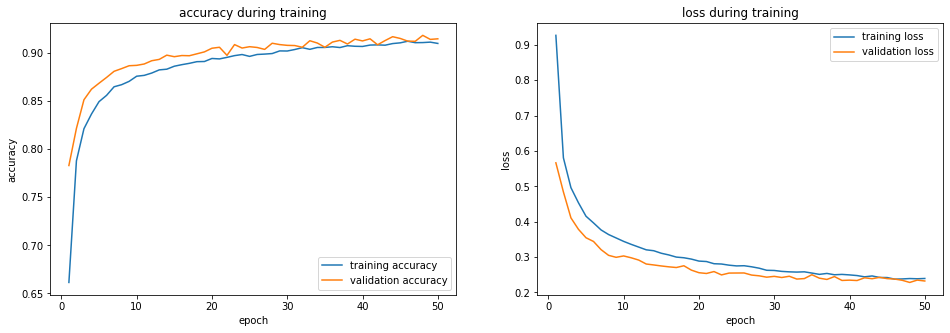

In [26]:
plot_history(history)

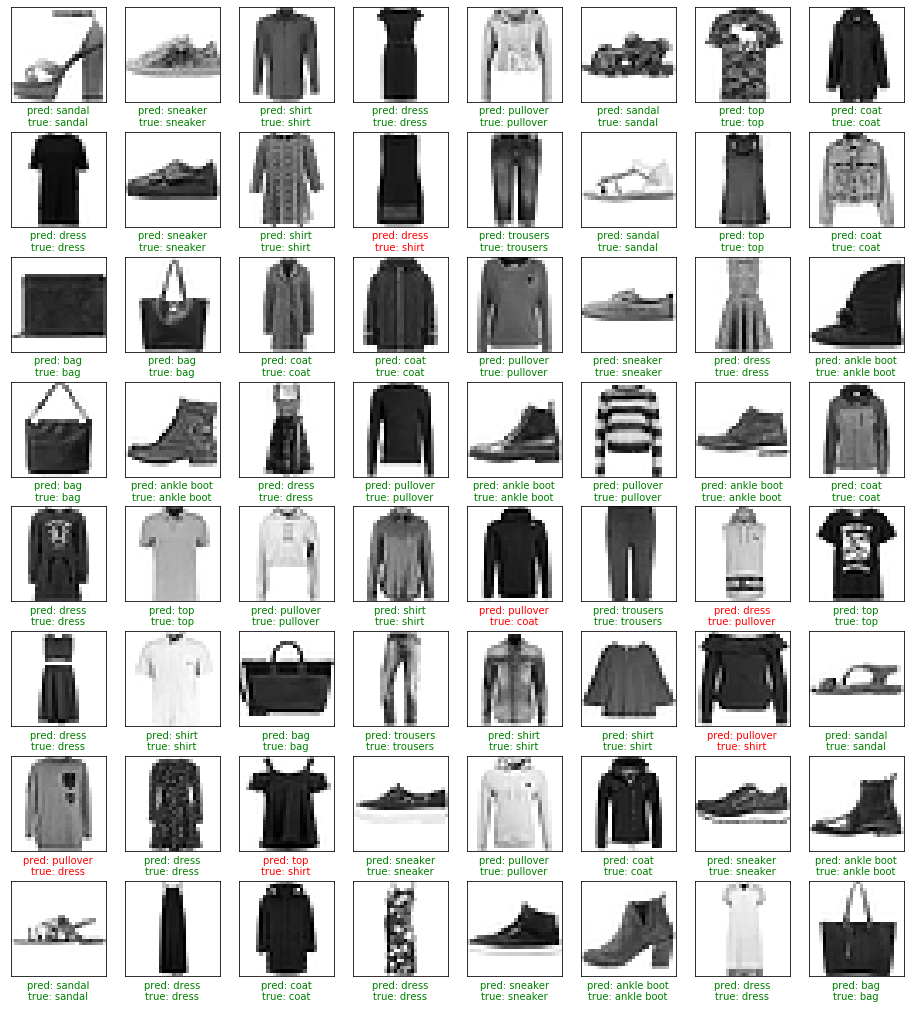

In [27]:
plot_predictions(models['convolutional net'])

In [28]:
data = OrderedDict()
for name, model in models.items():
    data[name] = OrderedDict([
        ('training set', f'{accuracy_score(train_y, model.predict(train_x)):.3f}'),
        ('validation set', f'{accuracy_score(val_y, model.predict(val_x)):.3f}'),
        ('test set', f'{accuracy_score(test_y, model.predict(test_x)):.3f}')])
display(DataFrame(data))

,nearest centroid,random forest,multilayer perceptron,convolutional net
training set,0.686,0.998,0.923,0.942
validation set,0.683,0.877,0.897,0.915
test set,0.678,0.873,0.888,0.913


In [29]:
data = OrderedDict()
for name, model in models.items():
    precision, recall, fscore, _ = precision_recall_fscore_support(
        test_y, model.predict(test_x))
    data[(name, 'precision')] = OrderedDict([
        (labels[i], f'{s:.3f}') for i, s in enumerate(precision)])
    data[(name, 'recall')] = OrderedDict([
        (labels[i], f'{s:.3f}') for i, s in enumerate(recall)])
    data[(name, 'f-score')] = OrderedDict(
        [(labels[i], f'{s:.3f}') for i, s in enumerate(fscore)])
display(DataFrame(data))

nearest centroid                random forest                 \
                  precision recall f-score     precision recall f-score   
top                   0.711  0.685   0.698         0.821  0.847   0.834   
trousers              0.975  0.880   0.925         0.993  0.964   0.978   
pullover              0.542  0.453   0.493         0.775  0.799   0.787   
dress                 0.688  0.769   0.726         0.873  0.901   0.887   
coat                  0.516  0.565   0.540         0.751  0.798   0.774   
sandal                0.496  0.776   0.605         0.974  0.957   0.965   
shirt                 0.338  0.214   0.262         0.699  0.599   0.645   
sneaker               0.762  0.821   0.791         0.926  0.947   0.936   
bag                   0.928  0.746   0.827         0.959  0.971   0.965   
ankle boot            0.860  0.868   0.864         0.947  0.944   0.945   

           multilayer perceptron                convolutional net         \
                       precision recall f-score         precision recall   
top                        0.819  0.866   0.842             0.859  0.880   
trousers                   0.995  0.973   0.984             0.992  0.979   
pullover                   0.773  0.829   0.800             0.864  0.870   
dress                      0.889  0.917   0.903             0.899  0.936   
coat                       0.812  0.793   0.802             0.857  0.847   
sandal                     0.985  0.956   0.970             0.984  0.979   
shirt                      0.736  0.639   0.684             0.766  0.727   
sneaker                    0.944  0.965   0.955             0.946  0.980   
bag                        0.970  0.980   0.975             0.982  0.979   
ankle boot                 0.956  0.967   0.961             0.979  0.955   

                    
           f-score  
top          0.869  
trousers     0.985  
pullover     0.867  
dress        0.917  
coat         0.852  
sandal       0.981  
shirt        0.746  
sneaker      0.963  
bag          0.980  
ankle boot   0.967

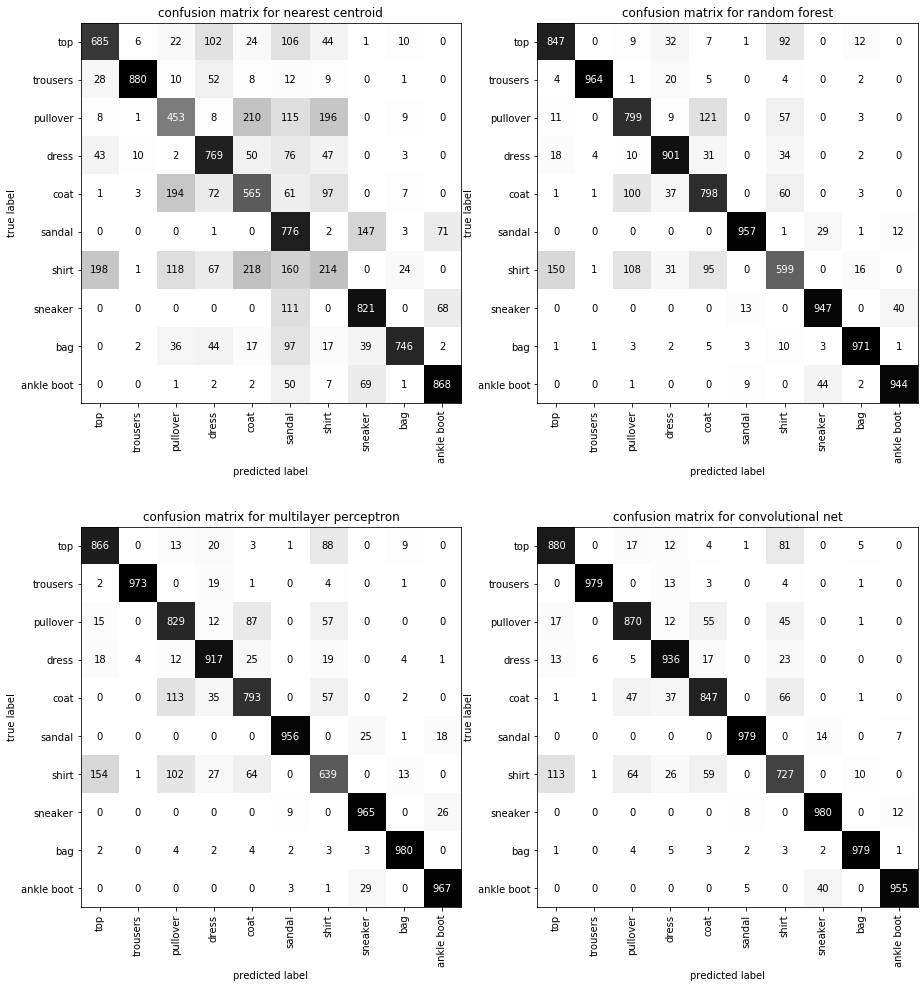

In [30]:
plt.figure(figsize=(15, 17))
for i, (name, model) in enumerate(models.items()):
    cm = confusion_matrix(test_y, model.predict(test_x))
    threshold = np.max(cm) / 2
    plt.subplot(2, 2, i + 1)
    plt.imshow(cm, cmap=plt.cm.binary)
    for i, _ in enumerate(labels):
        for j, _ in enumerate(labels):
            plt.text(
                j, i, cm[i, j], color='white' if cm[i, j] > threshold else 'black',
                horizontalalignment='center', verticalalignment='center')
    plt.title(f'confusion matrix for {name}')
    plt.xlabel('predicted label')
    plt.xticks(range(len(labels)), labels, rotation=90)
    plt.ylabel('true label')
    plt.yticks(range(len(labels)), labels)
plt.show()